## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.



### Dataset

In this homework, we will use the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
```

The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).


### Preparing the dataset 

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframe into matrices.

In [1]:
path_csv_file = '/workspace/homework/06-trees/housing.csv'

In [2]:
%%bash -s "$path_csv_file"

output_path=$1

if [ ! -f "$output_path" ]; then
    echo "File not found! Downloading it"
    wget -P "$(dirname "$output_path")" \
        https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
else
    echo "File already exists. Not downloading it"
fi

File already exists. Not downloading it


In [32]:
import pandas as pd
import numpy as np


import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [4]:
# load data
df = pd.read_csv(path_csv_file)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
# check for missing values
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [6]:
# # fill missing values with mean
# col_name_fillna = 'total_bedrooms'
# df[col_name_fillna] = df[col_name_fillna].mean()

# fill missing values with zeros
col_name_fillna = 'total_bedrooms'
df[col_name_fillna] = df[col_name_fillna].fillna(0)

In [7]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [8]:
# filter ocean_proximity and drop rows with values not in ['<1H OCEAN', 'INLAND']
indices_keep = df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])
indices_to_drop = ~indices_keep
df.drop(index=df.index[indices_to_drop], inplace=True)

<Axes: >

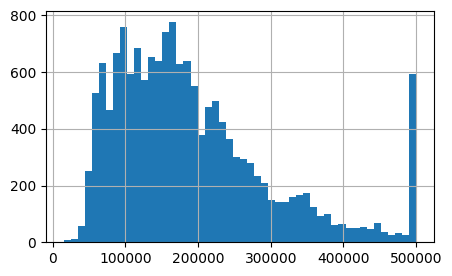

In [10]:
df.median_house_value.hist(bins=50, figsize=(5, 3))

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,12.973866,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,12.287657,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,12.419574,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,12.554971,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,12.287196,<1H OCEAN


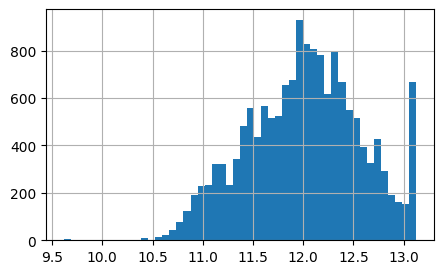

In [11]:
# apply log transformation to median_house_value
df.median_house_value = np.log1p(df.median_house_value)
df.median_house_value.hist(bins=50, figsize=(5, 3))
df.head()

In [12]:
# splitting the data into train, validation and test sets
random_state = 1
frac_train = 0.6
frac_val = 0.2
frac_test = 0.2

df_train_full, df_test = train_test_split(
    df, test_size=frac_test, shuffle=True, random_state=random_state)
df_train, df_val = train_test_split(
    df_train_full, test_size=frac_val/(frac_train+frac_val), shuffle=True, random_state=random_state)
display(df_train.head())
print(df_train.shape[0]/df.shape[0], df_val.shape[0]/df.shape[0], df_test.shape[0]/df.shape[0])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20101,-120.25,37.93,13.0,493.0,76.0,196.0,68.0,3.3750,11.806349,INLAND
5495,-118.40,34.00,10.0,1526.0,339.0,705.0,268.0,5.8083,12.681689,<1H OCEAN
19723,-121.67,38.85,46.0,645.0,131.0,410.0,122.0,1.7417,11.611874,INLAND
7876,-118.14,33.88,24.0,3305.0,982.0,2085.0,881.0,2.6641,12.032915,<1H OCEAN
7684,-118.11,33.92,34.0,1414.0,263.0,983.0,264.0,4.1767,11.961456,<1H OCEAN


0.5999235035379614 0.20003824823101932 0.20003824823101932


In [13]:
target_column = 'median_house_value'

dv = DictVectorizer(sparse=True)
dict_train = df_train.drop(columns=target_column).to_dict(orient='records')
dict_val = df_val.drop(columns=target_column).to_dict(orient='records')
dict_test = df_test.drop(columns=target_column).to_dict(orient='records')

X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)
X_test = dv.transform(dict_test)
y_train = df_train[target_column].copy().values
y_val = df_val[target_column].copy().values
y_test = df_test[target_column].copy().values

---

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity`
* `total_rooms`
* `latitude`
* `population`

### Solving 1

In [14]:
# training the regressior
dtr = DecisionTreeRegressor(max_depth=1, random_state=random_state)
dtr.fit(X_train, y_train)

# visualize the tree
export_text(dtr, feature_names=dv.feature_names_)

'|--- ocean_proximity=<1H OCEAN <= 0.50\n|   |--- value: [11.61]\n|--- ocean_proximity=<1H OCEAN >  0.50\n|   |--- value: [12.30]\n'

In [15]:
# get the decision rules of the tree
def get_decision_rules(tree, feature_names):
    thresholds = tree.threshold
    children_left = tree.children_left
    children_right = tree.children_right

    # define a recursive function to traverse the tree and print the decision rules
    def print_tree(node_id=0, indent=""):
        if node_id == -1:
            return
        if children_left[node_id] == -1 and children_right[node_id] == -1:
            print(f"{indent}return {tree.value[node_id]}")
            return
        feature = feature_names[tree.feature[node_id]]
        threshold = thresholds[node_id]
        print(f"{indent}if {feature} <= {threshold}:")
        print_tree(children_left[node_id], indent + "  ")
        print(f"{indent}else:")
        print_tree(children_right[node_id], indent + "  ")

    # print the decision rules of the tree
    print_tree()

get_decision_rules(dtr.tree_, dv.feature_names_)

if ocean_proximity=<1H OCEAN <= 0.5:
  return [[11.60680734]]
else:
  return [[12.30066927]]


### Answer 1

`ocean_proximity`

---

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* 0.245
* 0.545
* 0.845

In [33]:
# training the regressior
dtr = RandomForestRegressor(
    n_estimators=10, n_jobs=-1, random_state=1)
dtr.fit(X_train, y_train)

# evaluate RMSE on the validation set
y_pred = dtr.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE on validation set: {rmse:.3f}")


RMSE on validation set: 0.245


### Answer 2

In [34]:
print(f"{rmse:.3f}")

0.245


---

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- 10
- 25
- 50
- 160

In [18]:
start = 10
stop = 200
step = 10
num = (stop - start)//step + 1
estimators = np.linspace(start, stop, num, endpoint=True, dtype=int)
estimators

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])

In [19]:
rmse_estimators = []
for estimator in estimators:
    # training the regressior
    dtr = RandomForestRegressor(
        n_estimators=estimator, n_jobs=-1, random_state=1)
    dtr.fit(X_train, y_train)

    # evaluate RMSE on the validation set
    y_pred = dtr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_estimators.append((estimator, rmse))

df_rmse_estimators = pd.DataFrame(rmse_estimators, columns=['estimators', 'rmse'])

<Axes: xlabel='estimators'>

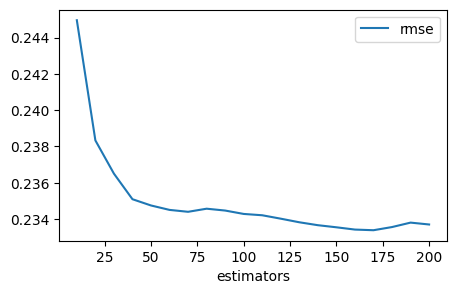

In [20]:
df_rmse_estimators.plot(x='estimators', y='rmse', figsize=(5, 3))

In [62]:
df_rmse_estimators.round(decimals=3).sort_values(by=['rmse','estimators'], ascending=True, inplace=False)

,max_depth,estimators,rmse
75,25,160,0.233
76,25,170,0.233
65,25,60,0.234
66,25,70,0.234
67,25,80,0.234
...,...,...,...
20,15,10,0.246
2,10,30,0.246
7,10,80,0.246
1,10,20,0.247


In [63]:
df_rmse_estimators.round(decimals=3).sort_values(by=['rmse','estimators'], ascending=True, inplace=False).iloc[0]

max_depth      25.000
estimators    160.000
rmse            0.233
Name: 75, dtype: float64

### Answer 3

`160`

---

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

* 10
* 15
* 20
* 25

In [46]:
max_depth_values = [10, 15, 20, 25]
rmse_estimators = []

for max_depth in max_depth_values:
    for estimator in estimators:
        # training the regressior
        dtr = RandomForestRegressor(
            n_estimators=estimator, 
            max_depth=max_depth,
            n_jobs=-1, random_state=1)
        dtr.fit(X_train, y_train)

        # evaluate RMSE on the validation set
        y_pred = dtr.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_estimators.append((max_depth, estimator, rmse))

df_rmse_estimators = pd.DataFrame(
    rmse_estimators, 
    columns=['max_depth', 'estimators', 'rmse'])

In [47]:
df_rmse_estimators.head()

,max_depth,estimators,rmse
0,10,10,0.250682
1,10,20,0.247455
2,10,30,0.246264
3,10,40,0.245029
4,10,50,0.245430


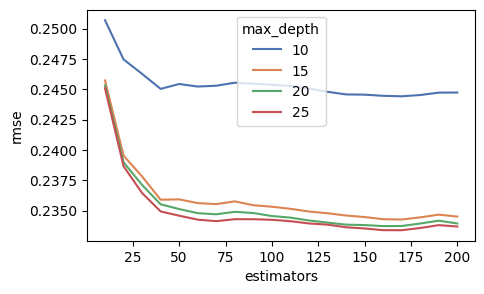

In [34]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(5, 3))
sns.lineplot(
    data=df_rmse_estimators, 
    x='estimators', y='rmse', hue='max_depth',
    palette='deep')
plt.show()

In [69]:
# group by max_depth and get the best estimator
# df_rmse_estimators.groupby('max_depth').apply(
#     lambda df: df.sort_values(by=['rmse', 'max_depth'], ascending=True))
#     #.iloc[0])
df_rmse_estimators.sort_values(by=['rmse', 'max_depth'], ascending=True)

,max_depth,estimators,rmse
76,25,170,0.233390
75,25,160,0.233395
74,25,150,0.233535
77,25,180,0.233572
73,25,140,0.233635
...,...,...,...
7,10,80,0.245536
20,15,10,0.245727
2,10,30,0.246264
1,10,20,0.247455


### Answer 4

`25`

---

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature? 

* `total_rooms`
* `median_income`	
* `total_bedrooms`
* `longitude`


### Solution 5

In [38]:
dtr = RandomForestRegressor(
    n_estimators=10, 
    max_depth=20,
    random_state=1,
    n_jobs=-1)
dtr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [40]:
df_feature_importance = pd.DataFrame(
    zip(dv.feature_names_, dtr.feature_importances_), 
    columns=['feature', 'importance'])
df_feature_importance.sort_values(by='importance', ascending=False)

,feature,importance
4,median_income,0.335668
5,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.101891
3,longitude,0.086176
6,ocean_proximity=INLAND,0.073806
1,housing_median_age,0.030194
7,population,0.026821
9,total_rooms,0.021772
8,total_bedrooms,0.016245
0,households,0.014953


### Answer 5

`median_income`

---

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both gives same

In [42]:
!pip install xgboost
import xgboost as xgb


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [137]:
# function from mlbookcamp
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        name_train, train = train_line.split(':')
        name_val, val = val_line.split(':')
        train = float(train)
        val = float(val)   
        results.append((it, train, val))
    
    columns = ['num_iter', name_train, name_val]
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

def parse_xgb_scores(scores):
    df_list = []    
    for score, output_stdout in scores.items():
        df_tmp = parse_xgb_output(output_stdout)
        df_list.append(df_tmp.assign(score=score))
    df_results = pd.concat(df_list)
    return df_results    

In [148]:
from IPython.utils.capture import capture_output
eta_values = [0.3, 0.1]
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
params = {
    'eta': eta_values[0], 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 0,
}
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

for eta in eta_values:
    params['eta'] = eta
    with capture_output(sys.stdout) as output:
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=100,
            evals=[(dtrain, 'train'), (dval, 'val')],
            verbose_eval=5,
        )
        scores[f'eta={eta}'] = output

In [160]:
df_scores = parse_xgb_scores(scores)
df_scores.head()

,num_iter,train-rmse,val-rmse,score
0,0,0.44350,0.44250,eta=0.3
1,5,0.25338,0.27463,eta=0.3
2,10,0.21444,0.25179,eta=0.3
3,15,0.19858,0.24522,eta=0.3
4,20,0.18524,0.23978,eta=0.3


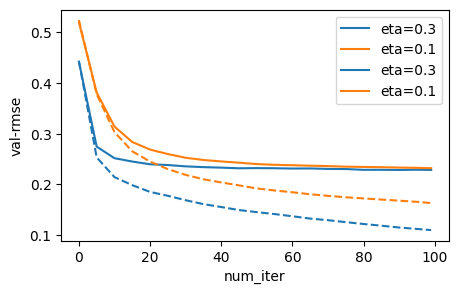

In [201]:
# print the scores as curve for each eta
plt.figure(figsize=(5, 3))
ax = plt.gca()
sns.lineplot(data=df_scores, x='num_iter', y='val-rmse', hue='score', ax=ax)
sns.lineplot(data=df_scores, x='num_iter', y='train-rmse', hue='score', ax=ax, linestyle='--')
plt.legend()
plt.show()


In [188]:
df_scores.round(decimals=3).sort_values(by=['val-rmse', 'num_iter'], ascending=True, inplace=False).head(7)	

,num_iter,train-rmse,val-rmse,score
16,80,0.122,0.229,eta=0.3
17,85,0.119,0.229,eta=0.3
18,90,0.115,0.229,eta=0.3
19,95,0.112,0.229,eta=0.3
20,99,0.110,0.229,eta=0.3
15,75,0.126,0.230,eta=0.3
12,60,0.137,0.231,eta=0.3


### Answer 6

`0.3`

---

## Submit the results

- Submit your results here: TBA
- If your answer doesn't match options exactly, select the closest one.
- You can submit your solution multiple times. In this case, only the last submission will be used

## Deadline

The deadline for submitting is October 23 (Monday), 23:00 CET. After that the form will be closed.